# Evaluate Model on Test Trajectories
We ran four new  trajecotries after training the model. In this notebook, we compare the validate the model's performance on that new data

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import pickle as pkl
import pandas as pd
import numpy as np
import os

## Load in the Tools
We'll need the data for these trajectories and a new model

In [2]:
with open(os.path.join('data', 'new_data.pkl'), 'rb') as fp:
    new_data = pkl.load(fp)

In [3]:
with open('traj_computer.pkl', 'rb') as fp:
    traj_computer = pkl.load(fp)

In [4]:
start_frame = pkl.load(open(os.path.join('..', 'al_starting_frame.pkl'), 'rb'))

In [5]:
new_data['channel'] = pd.read_pickle(os.path.join('data', 'channel_data.pkl.gz'))

In [6]:
new_data['random'] = pd.read_pickle(os.path.join('data', 'random_data.pkl.gz'))

## Run the Model on Each Trajectory
Use the model stored with the trajectory computer, which was trained on the random and channel trajectories

In [7]:
for subset in new_data.values():
    subset['force_pred'] = traj_computer.model.predict(subset[traj_computer.featurizers.feature_labels()])

## Compare the Model Accuracy
Get a sense for how well this model performed

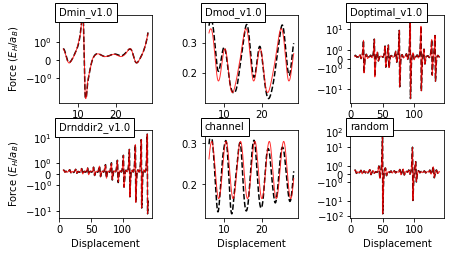

In [8]:
fig, axs = plt.subplots(2, 3)
axs = axs.flatten()

for i, (ax, (d, subset)) in enumerate(zip(axs, new_data.items())):
    subset = subset[~ subset['initial']]
    ax.plot(subset['displacement'], subset['force'], 'k--')
    ax.plot(subset['displacement'], subset['force_pred'], 'r', lw=1, alpha=0.8)
    
    if subset['force'].max() > 1:
        ax.set_yscale('symlog')
    
    # Make a label for the figure
    ax.text(0, 1, d, bbox={'facecolor': 'w', 'edgecolor': 'k'},
           transform=ax.transAxes)
    
    # Make axes labels
    if i >= 3:
        ax.set_xlabel('Displacement')
    if i % 3 == 0:
        ax.set_ylabel('Force ($E_H / a_B$)')
            
fig.tight_layout()
fig.set_size_inches(6.5, 3.5)
fig.savefig(os.path.join('figures', 'validation-set.png'), dpi=320)

*Finding*: Strong qualitative agreement with the stopping forces

# Compute Stopping Power for Channels
Two of the calculations are aligned along crystallographic axes. As such, we need to determine the stopping power along one repeat of the unit cell

In [9]:
def get_channel_stopping_power(data, direction):
    """Get the stopping power along a channel
    
    Args:
        data (DataFrame): TD-DFT data for a certain channel trajectory
        direction ([int]): Directions in lattice coordinates
    Returns:
        - (float) Stopping power from TD-DFT
        - (float) Stopping power from ML
    """
    
    # Get the length of the channel
    length = np.linalg.norm(traj_computer._compute_trajectory(direction))
    
    # Average over all possible choices
    max_distance = data['displacement'].max() - length
    stops = [
        data.query('displacement >= {} and displacement <= {}'.format(x['displacement'], x['displacement'] + length))['force'].mean()
        for i, x in data.query('displacement < {}'.format(max_distance)).iterrows()
    ]
    return np.median(stops), traj_computer.compute_stopping_power(data.iloc[0]['position'], direction, 1, abserr=1e-4)

Print out the results of each channel direction

In [10]:
channels = {
    'Dmod_v1.0': [2, 1, 1],
    'Dmin_v1.0': [1, 2, 2],
    'channel': [1, 0, 0]
}

In [11]:
for key, direct in channels.items():
    tddft, (ml, ml_err) = get_channel_stopping_power(new_data[key], direct)
    print('{}: TD-DFT: {:.3f} - ML {:.3f}'.format(key, tddft, ml))

Dmod_v1.0: TD-DFT: 0.234 - ML 0.233
Dmin_v1.0: TD-DFT: 0.268 - ML 0.245
channel: TD-DFT: 0.220 - ML 0.234


*Finding*: We overestimate the channel, are spot-on for the moderate stopping power, and underestimate the higher one. Kind of a "regression to the mean" type problem

## Compare the Ordering of Stopping Powers
See how well ML and TD-DFT match up

In [12]:
results = []
for key, subset in new_data.items():
    subset = subset[~ subset['initial']]
    results.append({'name': key, 'tddft': subset['force'].mean(), 'ml': subset['force_pred'].mean()})
results = pd.DataFrame(results)

In [13]:
results

,name,tddft,ml
0,Dmin_v1.0,0.270083,0.260794
1,Dmod_v1.0,0.241831,0.237271
2,Doptimal_v1.0,0.240920,0.242884
3,Drnddir2_v1.0,0.248845,0.249989
4,channel,0.221916,0.234292
5,random,0.240193,0.238360


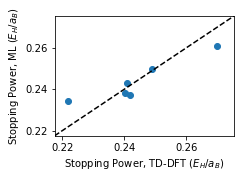

In [14]:
fig, ax = plt.subplots()

ax.scatter(results['tddft'], results['ml'])

min_value = results[['ml', 'tddft']].min().min() * 0.98
max_value = results[['ml', 'tddft']].max().max() * 1.02

ax.set_xlim([min_value, max_value])
ax.set_ylim(ax.get_xlim())

ax.plot(ax.get_xlim(), ax.get_ylim(), 'k--')

ax.set_xlabel('Stopping Power, TD-DFT ($E_H / a_B$)')
ax.set_ylabel('Stopping Power, ML ($E_H / a_B$)')

fig.set_size_inches(3.5, 2.5)
fig.tight_layout()
fig.savefig(os.path.join('figures', 'stopping-power-comparison.png'), dpi=320)

*Finding*: Get the order between the channels decently well, but overestimate the minimum and underestimate the maximum (not surprising as this is just a "regression to the mean")